# Learn Dimension Change with Conv2D

Learning goals:
Understand how the image dimension changes with the specification of Conv2D. How the values change as well.

Read https://pytorch.org/docs/master/generated/torch.nn.Conv2d.html
It has the formula to transform image sizes.

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import util
import copy
import cv2

# torch model
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
tnc = np.load('data_shenhao/cta/data_processed/TNC_tensor.npy')
print(tnc.shape)

(2976, 448, 256)


In [3]:
n_row = tnc.shape[1]
n_col = tnc.shape[2]
print(tnc.shape)

(2976, 448, 256)


In [4]:
idx = 80
tnc_idx = tnc[idx, :, :]
print(tnc_idx.shape)

(448, 256)


In [5]:
# create the pyramid.
tnc_level_0 = copy.deepcopy(tnc_idx)
tnc_level_1 = cv2.resize(tnc_level_0, (int(n_col/2), int(n_row/2)), interpolation = cv2.INTER_AREA) * 4
tnc_level_2 = cv2.resize(tnc_level_1, (int(n_col/4), int(n_row/4)), interpolation = cv2.INTER_AREA) * 4
tnc_level_3 = cv2.resize(tnc_level_2, (int(n_col/8), int(n_row/8)), interpolation = cv2.INTER_AREA) * 4
tnc_level_4 = cv2.resize(tnc_level_3, (int(n_col/16), int(n_row/16)), interpolation = cv2.INTER_AREA) * 4
tnc_level_5 = cv2.resize(tnc_level_4, (int(n_col/32), int(n_row/32)), interpolation = cv2.INTER_AREA) * 4

print(tnc_level_0.shape)
print(tnc_level_1.shape)
print(tnc_level_2.shape)
print(tnc_level_3.shape)
print(tnc_level_4.shape)
print(tnc_level_5.shape)

print("Sum matches?")
print(np.sum(tnc_level_0), np.sum(tnc_level_1), np.sum(tnc_level_3), np.sum(tnc_level_5))


(448, 256)
(224, 128)
(112, 64)
(56, 32)
(28, 16)
(14, 8)
Sum matches?
3285.0000066504995 3285.0000066505 3285.0000066505 3285.0000066505004


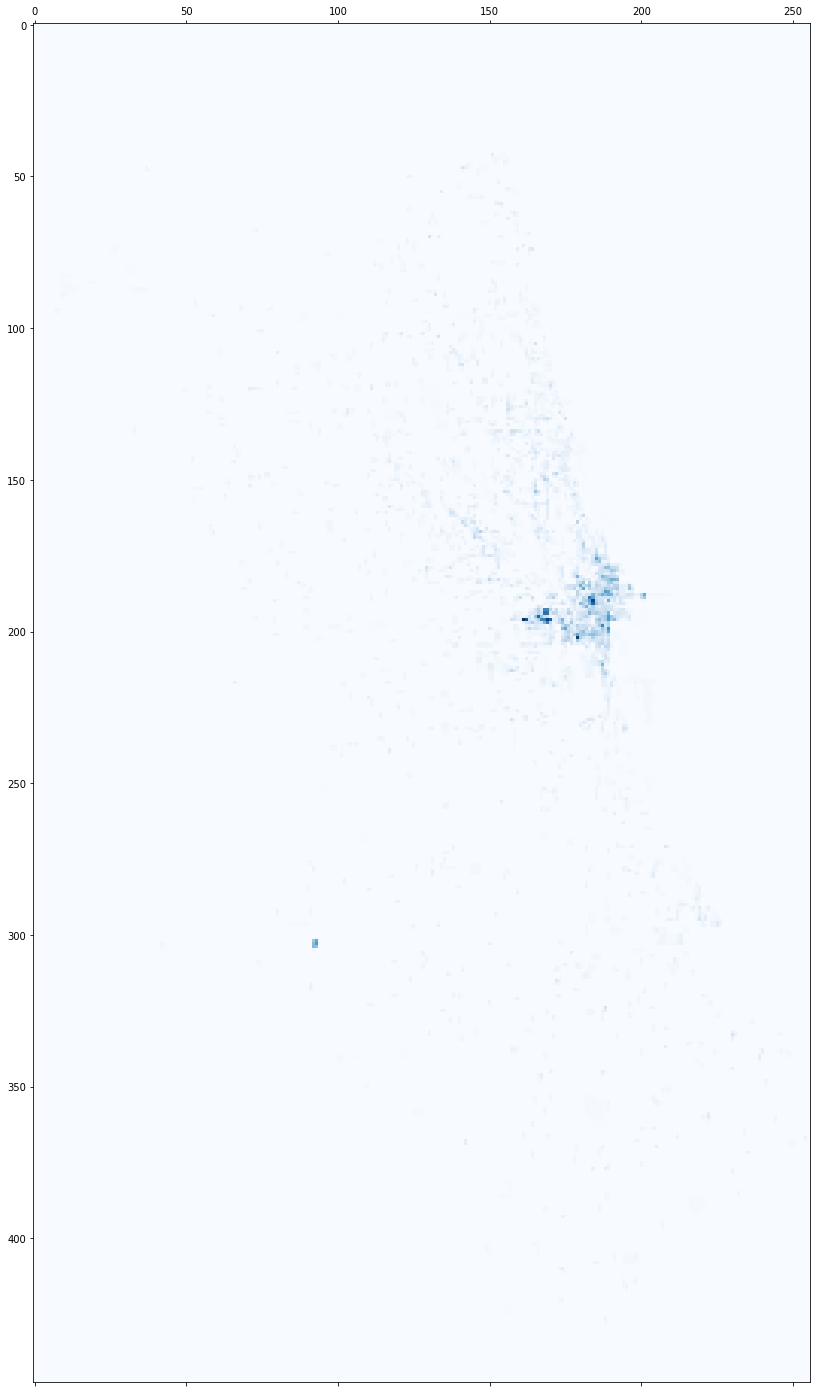

In [6]:
fig, ax = plt.subplots(figsize = (25,25))
ax.matshow(np.round(tnc_level_0, decimals = 2), cmap = plt.cm.Blues)


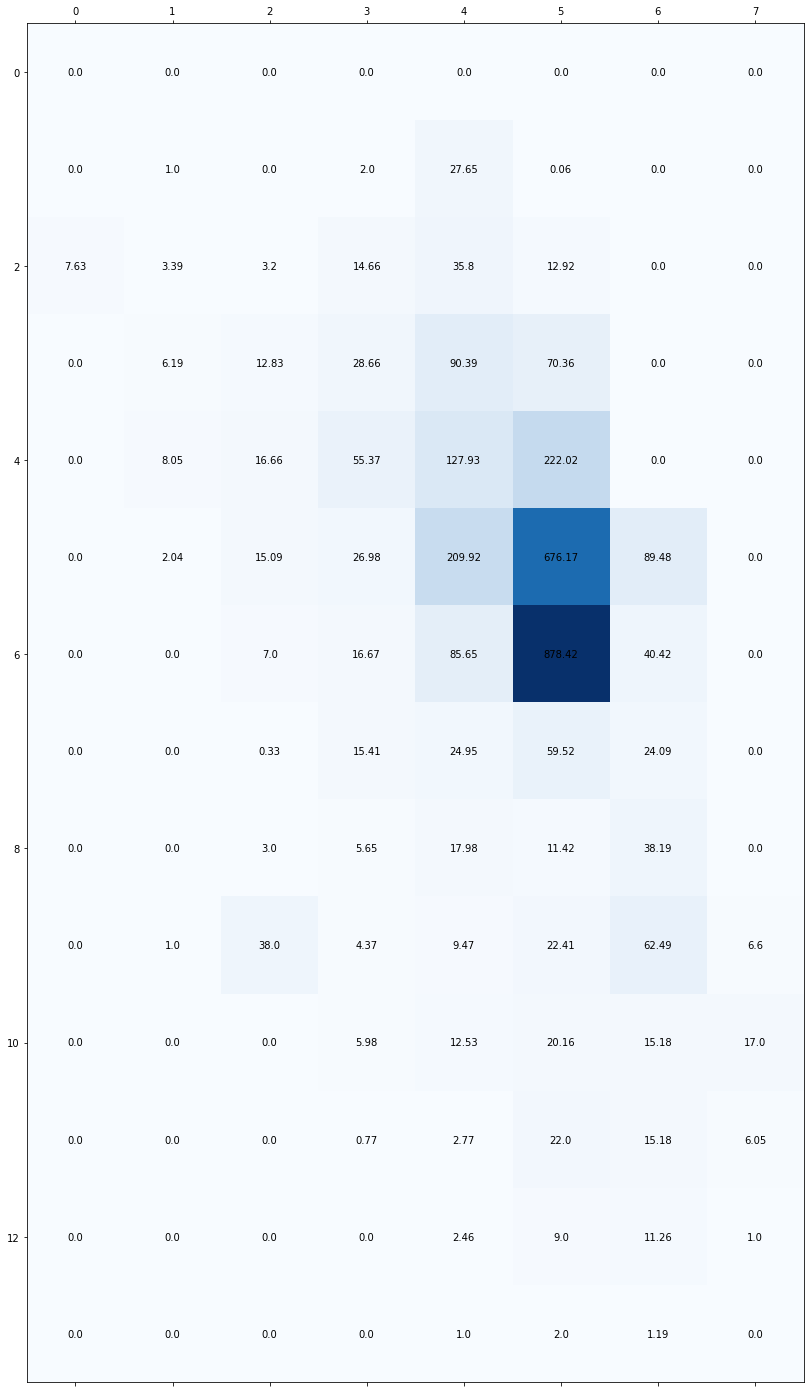

In [6]:
# visualize level 5.
def matrix_val(m, num_row, num_col):
    fig, ax = plt.subplots(figsize = (25,25))
    ax.matshow(np.round(m, decimals = 2), cmap = plt.cm.Blues)
    for i in range(int(num_row)):
        for j in range(int(num_col)):
            c = np.round(m, decimals = 2)[i,j]
            ax.text(j, i, str(c), va='center', ha='center')

matrix_val(tnc_level_5, n_row/32, n_col/32)

## CNN Dimension and Values: Ex 1.

In [24]:
class Net0(nn.Module):
    # sw: again. It is critical to understand the dimension transformation.
    def __init__(self):
        super(Net0, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels = 3, kernel_size = (3,3), padding = 1, bias = False) # sw: change the input channel for data set.

    def forward(self, x):
        x = self.conv1(x)
        return x

In [25]:
inputs = torch.from_numpy(tnc_level_5[np.newaxis,np.newaxis, :].astype('float32'))
print(inputs.shape)

torch.Size([1, 1, 14, 8])


In [26]:
net = Net0()
for param in net.conv1.parameters():
    print(param)

print(net.conv1.weight.size())
net.conv1.weight = torch.nn.Parameter(torch.ones((3,1,3,3))/9.0)
print(net.conv1.weight.size())

Parameter containing:
tensor([[[[-0.0034, -0.0848, -0.0392],
          [-0.1725,  0.2405, -0.2668],
          [-0.1014,  0.1450,  0.0274]]],


        [[[ 0.3147,  0.0849, -0.0156],
          [ 0.2589,  0.3188, -0.2468],
          [ 0.1898,  0.1754,  0.0870]]],


        [[[ 0.0078,  0.1024,  0.0062],
          [ 0.1856,  0.2285, -0.3177],
          [-0.1525,  0.1727,  0.1766]]]], requires_grad=True)
torch.Size([3, 1, 3, 3])
torch.Size([3, 1, 3, 3])


In [15]:
outputs = net(inputs)
outputs_np = outputs.detach().numpy()

In [16]:
outputs_np.shape

(1, 3, 14, 8)

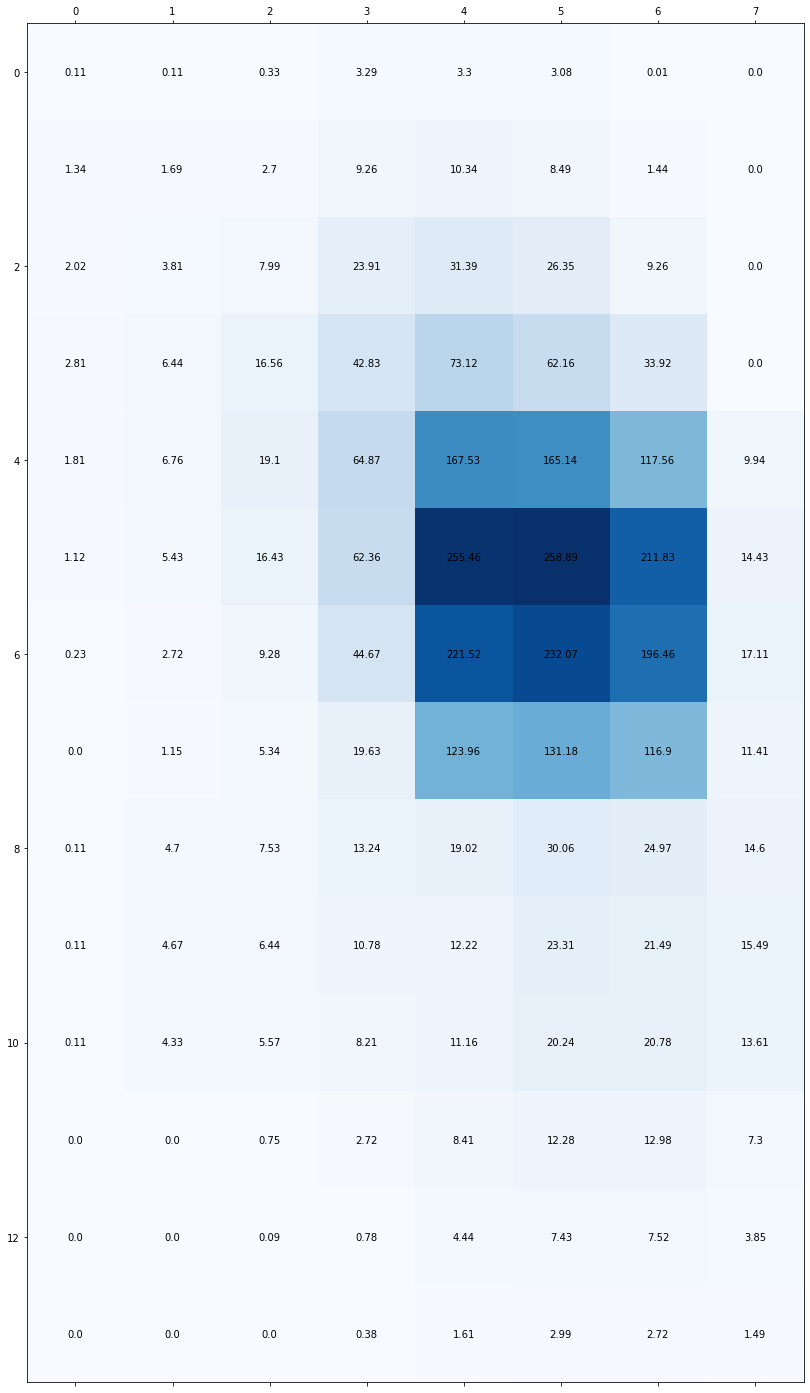

In [17]:
matrix_val(outputs_np[0,0,], 14, 8)

#### Lessons Learnt
The kernel size (3,3) and the padding = 1 maintains the size of the images. The current specification of values in conv kernels compute the averages of the neighboring nine units. Even in the padding region, the values are not zeros but still the averaging of neighboring values. Also note the size of the parameters matching to the parameters. 

## CNN Dimension and Values: Ex 2.

In [65]:
class Net1(nn.Module):
    # sw: again. It is critical to understand the dimension transformation.
    def __init__(self):
        super(Net1, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels = 1, kernel_size = (5,5), padding = 2, bias = False) # sw: change the input channel for data set.

    def forward(self, x):
        x = self.conv1(x)
        return x

In [66]:
inputs = torch.from_numpy(tnc_level_5[np.newaxis,np.newaxis, :].astype('float32'))
print(inputs.shape)

torch.Size([1, 1, 14, 8])


In [67]:
net = Net1()
for param in net.conv1.parameters():
    print(param)

net.conv1.weight = torch.nn.Parameter(torch.ones((1,1,5,5))/25.0)
print(net.conv1.weight.size())
for param in net.conv1.parameters():
    print(param)


Parameter containing:
tensor([[[[-0.0692, -0.0966, -0.0914,  0.1814,  0.0340],
          [-0.0591, -0.0851,  0.0957,  0.1051,  0.0491],
          [ 0.1187,  0.1916, -0.1055,  0.0145,  0.0689],
          [-0.1112,  0.1340, -0.0334, -0.1466, -0.0373],
          [ 0.1259, -0.1161,  0.0170, -0.1294,  0.0327]]]], requires_grad=True)
torch.Size([1, 1, 5, 5])
Parameter containing:
tensor([[[[0.0400, 0.0400, 0.0400, 0.0400, 0.0400],
          [0.0400, 0.0400, 0.0400, 0.0400, 0.0400],
          [0.0400, 0.0400, 0.0400, 0.0400, 0.0400],
          [0.0400, 0.0400, 0.0400, 0.0400, 0.0400],
          [0.0400, 0.0400, 0.0400, 0.0400, 0.0400]]]], requires_grad=True)


In [68]:
outputs = net(inputs)
outputs_np = outputs.detach().numpy()
outputs_np.shape

(1, 1, 14, 8)

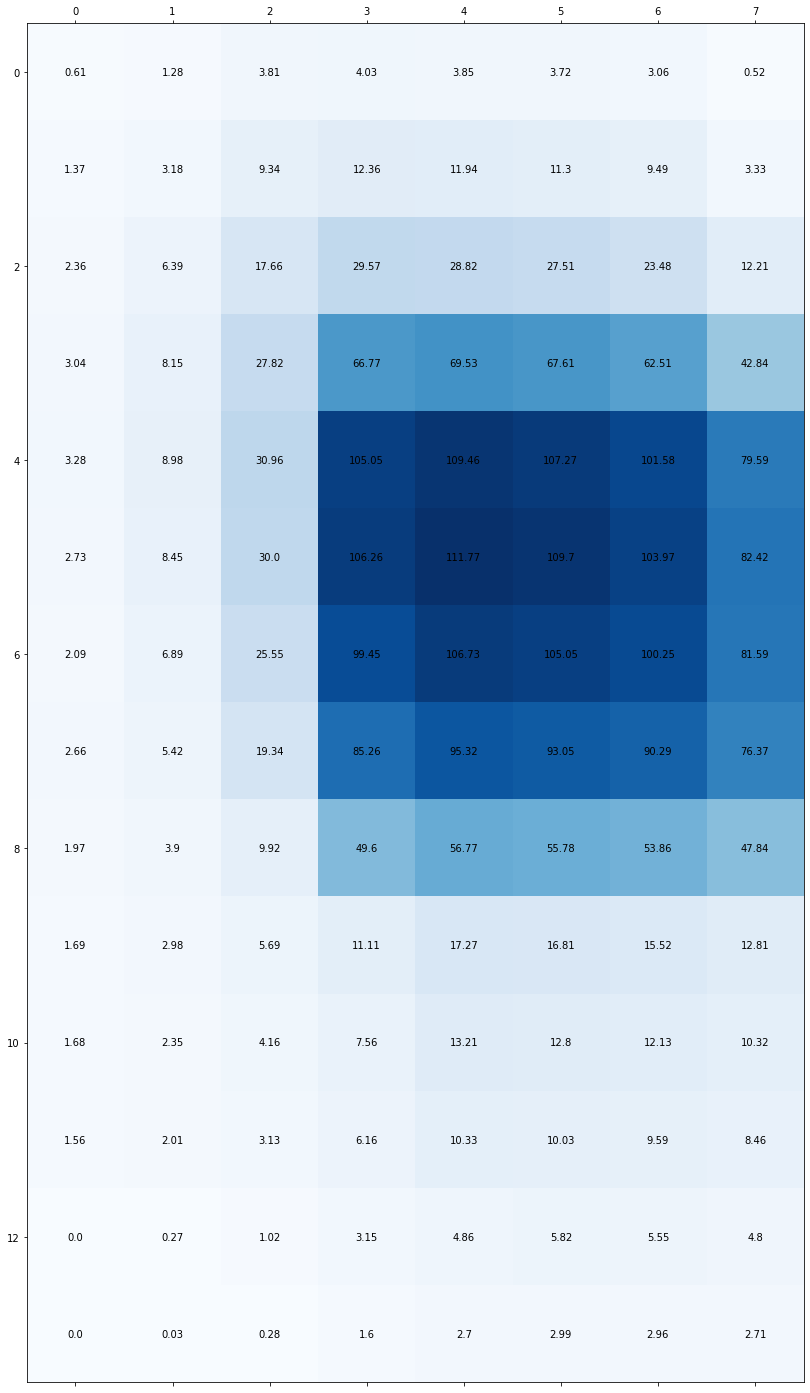

In [70]:
matrix_val(outputs_np[0,0,], 14, 8)

#### Lessons Learnt
When kernel sizes are evern numbers, it is hard to use padding to maintain the raw image size and to visualize the mapping. But the computation hold, and the new image size reduces by (s-1, s-1). When kernel sizes are odd numbers, it is easier for visualizing the pixel mapping and using padding to maintain the raw image size. e.g. kernel size = (5,5), padding = 2, then the image size is maintained. If you want to maintain the image size, then don't use stride > 1.

## CNN Dimension and Values: Ex 3.
Goal: Use Conv layers to construct an image pyramid size change.

In [87]:
class Net2(nn.Module):
    # sw: again. It is critical to understand the dimension transformation.
    def __init__(self):
        super(Net2, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels = 1, kernel_size = (5,5), padding = 2, stride=2, bias = False) # sw: change the input channel for data set.

    def forward(self, x):
        x = self.conv1(x)
        return x

In [88]:
inputs = torch.from_numpy(tnc_level_0[np.newaxis,np.newaxis, :].astype('float32'))
print(inputs.shape)

torch.Size([1, 1, 448, 256])


In [89]:
net = Net2()
for param in net.conv1.parameters():
    print(param)

net.conv1.weight = torch.nn.Parameter(torch.ones((1,1,5,5))/25.0)
print(net.conv1.weight.size())
for param in net.conv1.parameters():
    print(param)

Parameter containing:
tensor([[[[ 0.1343, -0.1367,  0.1939,  0.1727, -0.0698],
          [ 0.1189,  0.0932,  0.0590, -0.1508, -0.0623],
          [-0.1095,  0.1195, -0.1205, -0.1852, -0.0207],
          [ 0.0499, -0.0525, -0.0928, -0.0107,  0.1439],
          [-0.1648,  0.1946, -0.0142,  0.0429, -0.1675]]]], requires_grad=True)
torch.Size([1, 1, 5, 5])
Parameter containing:
tensor([[[[0.0400, 0.0400, 0.0400, 0.0400, 0.0400],
          [0.0400, 0.0400, 0.0400, 0.0400, 0.0400],
          [0.0400, 0.0400, 0.0400, 0.0400, 0.0400],
          [0.0400, 0.0400, 0.0400, 0.0400, 0.0400],
          [0.0400, 0.0400, 0.0400, 0.0400, 0.0400]]]], requires_grad=True)


In [90]:
outputs = net(inputs)
outputs_np = outputs.detach().numpy()
outputs_np.shape

(1, 1, 224, 128)

#### Lessons Learnt
Roughy speaking, when I use the kernels and paddings to maintain the raw image size, then I can just change the stride values to create the image pyramid. However, you should check the documentation for the exact formula.

## CNN Dimension and Values: Ex 4
Goal: Creat a sequence of image pyramid with Conv and Maxpooling layers and ends with global averaging layer. Then export the sequence of image pyramid layers.  

In [152]:
class Net3(nn.Module):
    def __init__(self):
        super(Net3, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels = 1, kernel_size = (5,5), padding=2, stride=2, bias = False)
        self.pool1 = nn.MaxPool2d(kernel_size = (5,5), padding=2, stride=1, dilation = 1)
        self.conv2 = nn.Conv2d(in_channels=1, out_channels = 1, kernel_size = (5,5), padding=2, stride=2, bias = False)
        self.pool2 = nn.MaxPool2d(kernel_size = (5,5), padding=2, stride=1, dilation = 1)
        self.conv3 = nn.Conv2d(in_channels=1, out_channels = 1, kernel_size = (5,5), padding=2, stride=2, bias = False) 
        self.pool3 = nn.MaxPool2d(kernel_size = (5,5), padding=2, stride=1, dilation = 1)
        self.avgpool = nn.AvgPool2d(kernel_size = (56, 32))
        
    def forward(self, x):
        self.x0 = self.conv1(x) # (224, 128)
        self.x0 = self.pool1(self.x0)
        self.x1 = self.conv2(self.x0) # (112, 64)
        self.x1 = self.pool2(self.x1)
        self.x2 = self.conv3(self.x1) # (56, 32)
        self.x2 = self.pool3(self.x2)
        self.x3 = self.avgpool(self.x2) # 
        return self.x3


In [153]:
# expected dimensions: (448, 256), (224, 128), (112, 64), (56, 32)

In [154]:
inputs = torch.from_numpy(tnc_level_0[np.newaxis,np.newaxis, :].astype('float32'))
print(inputs.shape)

torch.Size([1, 1, 448, 256])


In [155]:
net = Net3()
for param in net.parameters():
    print(param)

Parameter containing:
tensor([[[[ 0.1242, -0.0394,  0.0868,  0.1250,  0.1884],
          [-0.1827,  0.1991,  0.1493, -0.0911, -0.1955],
          [-0.1303, -0.1635, -0.0408, -0.1081,  0.0770],
          [ 0.0593, -0.0776, -0.0975, -0.0691,  0.1989],
          [ 0.0623, -0.0875, -0.1001,  0.1362, -0.0533]]]], requires_grad=True)
Parameter containing:
tensor([[[[-0.0863,  0.1875, -0.1635,  0.1751,  0.0152],
          [-0.0581,  0.0278,  0.0126,  0.0826, -0.0456],
          [-0.0626, -0.0613, -0.1731, -0.1172, -0.1847],
          [ 0.1878, -0.0697,  0.1083, -0.1516, -0.1807],
          [ 0.1801,  0.0899, -0.1359,  0.1694, -0.0925]]]], requires_grad=True)
Parameter containing:
tensor([[[[-0.0965, -0.1249,  0.0460,  0.0316, -0.1546],
          [-0.0019,  0.1870, -0.1690,  0.0304, -0.0464],
          [-0.0250, -0.1050, -0.0384,  0.0712, -0.1957],
          [-0.1960, -0.0026, -0.0033, -0.0521, -0.1733],
          [ 0.1709, -0.1450, -0.1100,  0.0483,  0.0104]]]], requires_grad=True)


In [156]:
outputs = net(inputs)
outputs_np = outputs.detach().numpy()
outputs_np.item()

-0.0022848399821668863

In [161]:
print(net.x0.size())
print(net.x1.size())
print(net.x2.size())
print(net.x3.size())

torch.Size([1, 1, 224, 128])
torch.Size([1, 1, 112, 64])
torch.Size([1, 1, 56, 32])
torch.Size([1, 1, 1, 1])


#### Lessons Learnt
Continue the discussions above. nn.MaxPool2d defaults use stride that takes the same value as kernel_size. Without explicitly specifying the stride values, the image size starts to shrink a lot with the specified kernel size. Therefore, to have a precise size control, you need to specify stride value for MaxPool2d. In addition, the global averaging layer is just some nn.AvgPool2d with the right size control.